# Classification Multiclass

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Mitchell-Mirano/sorix/blob/qa/docs/examples/nn/2.2-classification-multiclass.ipynb)
[![Open in GitHub](https://img.shields.io/badge/Open%20in-GitHub-black?logo=github)](https://github.com/Mitchell-Mirano/sorix/blob/qa/docs/examples/nn/2.2-classification-multiclass.ipynb)
[![Open in Docs](https://img.shields.io/badge/Open%20in-Docs-blue?logo=readthedocs)](https://mitchell-mirano.github.io/sorix/latest/examples/nn/2.2-classification-multiclass)

In [1]:
# Uncomment the following line to install GPU version with Cupy backend
#!pip install 'sorix @ git+https://github.com/Mitchell-Mirano/sorix.git@qa/docs_learn/docs_learn/docs_learn/docs_learn'

In [2]:
import joblib
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 

import sorix
from sorix.nn import ReLU,Linear
from sorix.optim import SGDMomentum,RMSprop,Adam,SGD
from sorix import tensor,Tensor
from sorix.nn import Module
from sorix.nn import CrossEntropyLoss
from sorix.metrics import confusion_matrix,classification_report
from sorix.model_selection import train_test_split

In [3]:
device = 'cuda' if sorix.cuda.is_available() else 'cpu'
device

✅ GPU basic operation passed
✅ GPU available: NVIDIA GeForce RTX 4070 Laptop GPU
CUDA runtime version: 13000
CuPy version: 14.0.1


'cuda'

## Datos

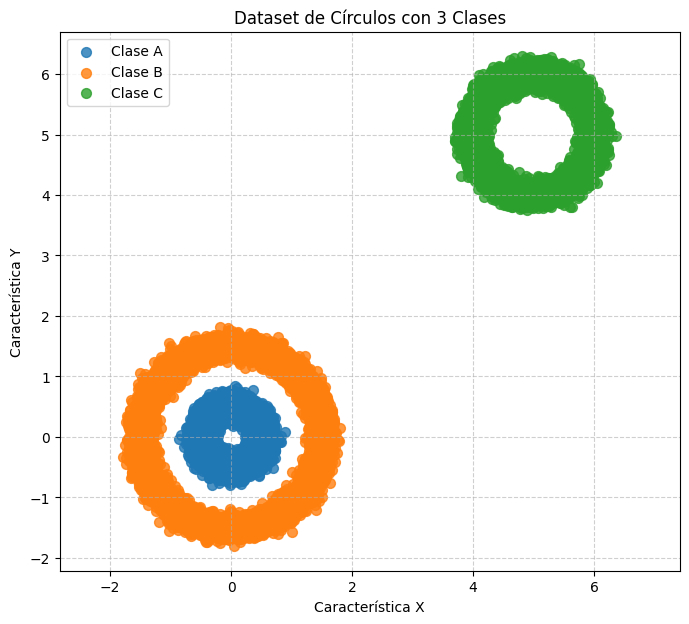

In [4]:
r1 = 0.5  
r2 = 1.5  
r3 = 1  

num_points = 10000
thetas = np.linspace(0, 2 * np.pi, num_points) 


x1 = r1 * np.cos(thetas) + 0.1 * np.random.randn(num_points)
y1 = r1 * np.sin(thetas) + 0.1 * np.random.randn(num_points)


x2 = r2 * np.cos(thetas) + 0.1 * np.random.randn(num_points)
y2 = r2 * np.sin(thetas) + 0.1 * np.random.randn(num_points)


x3 = 5 + r3 * np.cos(thetas) + 0.1 * np.random.randn(num_points)
y3 = 5 + r3 * np.sin(thetas) + 0.1 * np.random.randn(num_points)


plt.figure(figsize=(8, 7)) 


plt.scatter(x1, y1, s=50, label="Clase A", alpha=0.8) # Puntos de la Clase A
plt.scatter(x2, y2, s=50, label="Clase B", alpha=0.8) # Puntos de la Clase B
plt.scatter(x3, y3, s=50, label="Clase C", alpha=0.8) # Puntos de la Clase C

plt.xlabel("Característica X") 
plt.ylabel("Característica Y")
plt.title("Dataset de Círculos con 3 Clases")
plt.legend() 
plt.grid(True, linestyle='--', alpha=0.6)
plt.axis('equal')
plt.show() 


In [5]:
df = pd.DataFrame(
    {"x": x1.tolist()+x2.tolist()+x3.tolist(),
    "y": y1.tolist()+y2.tolist()+y3.tolist(),
    "labels":['A' for _ in range(num_points)]+['B' for _ in range(num_points)]+['C' for _ in range(num_points)]
    })

labels = df["labels"].unique()
labels2id = {label: i for i, label in enumerate(labels)}
id2labels = {v: k for k, v in labels2id.items()}

df["labels"] = df["labels"].map(labels2id)
df.head()

,x,y,labels
0,0.502291,0.023374,0
1,0.471920,0.121372,0
2,0.531328,-0.078208,0
3,0.471919,-0.123413,0
4,0.363109,-0.034028,0


In [6]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)


X_train = tensor(df_train[["x","y"]].values).to(device)
Y_train = tensor(df_train[["labels"]].values).to(device)
X_test = tensor(df_test[["x","y"]].values).to(device)
Y_test = tensor(df_test[["labels"]].values).to(device)

print(f"X_train shape: {X_train.shape}, device: {X_train.device}")
print(f"Y_train shape: {Y_train.shape}, device: {Y_train.device}")
print(f"X_test shape: {X_test.shape}, device: {X_test.device}")
print(f"Y_test shape: {Y_test.shape}, device: {Y_test.device}")


X_train shape: sorix.Size([24000, 2]), device: cuda:0
Y_train shape: sorix.Size([24000, 1]), device: cuda:0
X_test shape: sorix.Size([6000, 2]), device: cuda:0
Y_test shape: sorix.Size([6000, 1]), device: cuda:0


In [7]:
X_train.grad

In [8]:
class Network(Module):
    def __init__(self):
        super().__init__()
        self.fc1 = Linear(2, 4)
        self.relu = ReLU()
        self.fc2 = Linear(4, 4)
        self.fc3 = Linear(4, 3)

    def forward(self, x: tensor) -> Tensor:
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x


net = Network().to(device)
net.parameters()

[tensor([[ 0.8218481 ,  1.6584973 , -0.21329844, -0.22710423],
         [-1.283966  ,  1.0882515 , -0.06972136, -0.03704953]], device='cuda:0', requires_grad=True),
 tensor([[0., 0., 0., 0.]], device='cuda:0', requires_grad=True),
 tensor([[ 0.30648765,  0.21343027, -0.09919398,  0.9340736 ],
         [-1.133978  ,  0.14940731,  0.28791216, -0.29160607],
         [ 0.43589577,  0.4688745 ,  0.78475726, -0.0788846 ],
         [-0.15354739,  0.38126808, -0.13964173, -1.0757526 ]], device='cuda:0', requires_grad=True),
 tensor([[0., 0., 0., 0.]], device='cuda:0', requires_grad=True),
 tensor([[ 0.60982543, -1.2970355 ,  0.28402847],
         [ 1.7949859 ,  0.37703976, -0.49080712],
         [-0.31916267,  0.26207057, -0.01511212],
         [ 0.5347513 ,  1.025364  ,  0.9294297 ]], device='cuda:0', requires_grad=True),
 tensor([[0., 0., 0.]], device='cuda:0', requires_grad=True)]

In [9]:
criterion = CrossEntropyLoss()
optimizer = RMSprop(net.parameters(), lr=1e-2)

In [10]:
logits = net(X_train)
logits

tensor([[ 0.12976858,  0.0970069 , -0.05718071],
        [ 2.64313017,  1.9758392 , -1.16465833],
        [ 2.45234262,  1.83321833, -1.08059047],
        ...,
        [ 2.22724158,  1.66494684, -0.98140284],
        [ 2.10826844,  1.57600994, -0.92897899],
        [ 0.28654481,  0.15230036, -0.10700498]], device='cuda:0', dtype=sorix.float64, requires_grad=True)

In [11]:
preds = sorix.argmax(logits, axis=1, keepdims=True)
preds

tensor([[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]], device='cuda:0', dtype=sorix.int64)

## Training

In [12]:
# Bucle de entrenamiento mejorado
for epoch in range(10000 + 1):
    logits = net(X_train)
    loss = criterion(logits, Y_train)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        preds = sorix.argmax(logits, axis=1, keepdims=True)
        acc_train = (preds == Y_train).mean()
        with sorix.no_grad():
            logits = net(X_test)
            preds = sorix.argmax(logits, axis=1, keepdims=True)
            acc_test = (preds == Y_test).mean()

        # Usamos una f-string para formatear y alinear la salida
        print(f"[{device}] Epoch {epoch:5d} | Loss: {loss.item():.4f} | Acc Train: {acc_train.item()*100:.2f}% | Acc Test: {acc_test.item()*100:.2f}%")

        if acc_test.item() >= 0.98:  # Mejoramos el criterio de parada
            print(f"Entrenamiento completado en {epoch} epochs!")
            break


[cuda] Epoch     0 | Loss: 2.0356 | Acc Train: 33.73% | Acc Test: 20.73%
[cuda] Epoch    10 | Loss: 0.8267 | Acc Train: 77.54% | Acc Test: 78.52%
[cuda] Epoch    20 | Loss: 0.5944 | Acc Train: 79.47% | Acc Test: 80.15%
[cuda] Epoch    30 | Loss: 0.4896 | Acc Train: 80.84% | Acc Test: 81.70%
[cuda] Epoch    40 | Loss: 0.4190 | Acc Train: 83.32% | Acc Test: 83.98%
[cuda] Epoch    50 | Loss: 0.3617 | Acc Train: 85.93% | Acc Test: 86.53%
[cuda] Epoch    60 | Loss: 0.3075 | Acc Train: 88.50% | Acc Test: 88.35%
[cuda] Epoch    70 | Loss: 0.2525 | Acc Train: 94.22% | Acc Test: 94.20%
[cuda] Epoch    80 | Loss: 0.2022 | Acc Train: 96.98% | Acc Test: 96.72%
[cuda] Epoch    90 | Loss: 0.1609 | Acc Train: 98.27% | Acc Test: 98.05%
Entrenamiento completado en 90 epochs!


## Prediction

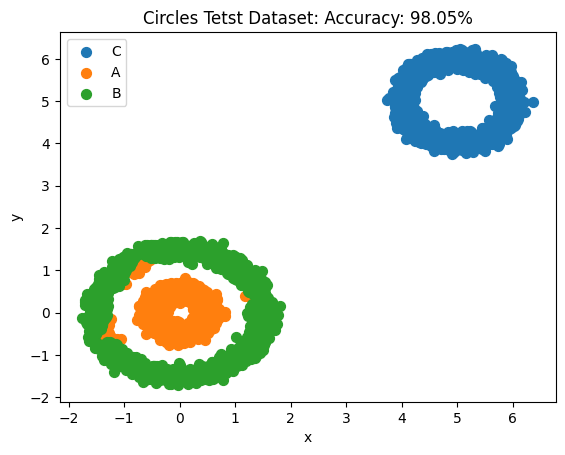

In [13]:
with sorix.no_grad():
    logits = net(X_test)

preds = sorix.argmax(logits, axis=1, keepdims=True)
acc = (preds == Y_test).mean()   


y_pred_labels = [id2labels[y.item()] for y in preds]

df_test['pred_labels'] = y_pred_labels

for label in df_test['pred_labels'].unique():
    x = df_test[df_test['pred_labels'] == label]['x']
    y = df_test[df_test['pred_labels'] == label]['y']

    plt.scatter(x,y,s=50,label=label)

plt.title(f"Circles Tetst Dataset: Accuracy: {100*acc.item():.2f}%")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()

<Axes: >

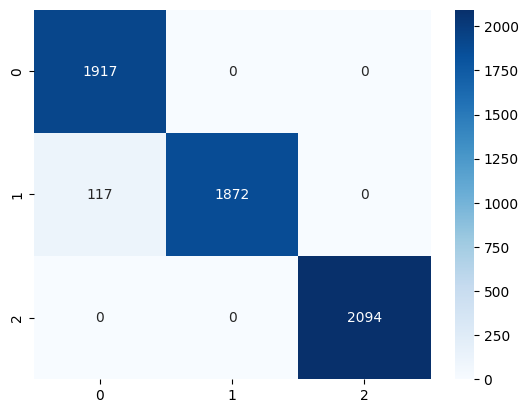

In [14]:
sns.heatmap(confusion_matrix(Y_test, preds), annot=True, cmap="Blues", fmt=".0f")

In [15]:
print(classification_report(Y_test, preds))

            precision   recall f1-score  support
0                0.94     1.00     0.97     1917
1                1.00     0.94     0.97     1989
2                1.00     1.00     1.00     2094

accuracy                           0.98     6000
macro avg        0.98     0.98     0.98     6000
weighted avg     0.98     0.98     0.98     6000


## Save and Load Model

In [16]:
sorix.save(net.state_dict(),"model_weights.sor")

## CPU

In [17]:
net2 = Network()
net2.load_state_dict(sorix.load("model_weights.sor"))

if X_test.device == 'cpu':
    with sorix.no_grad():
        logits = net2(X_test)
if X_test.device == 'cuda':
    with sorix.no_grad():
        logits = net2(X_test.to('cpu'))

logits

tensor([[-17.36036001,   3.77189297,   8.35657141],
        [-19.42832721,   4.38193053,   9.66869124],
        [-17.07820553,   3.54820426,   8.250104  ],
        ...,
        [  4.48506094,   2.25405481,  -2.85032539],
        [  1.70595854,   1.15646953,  -1.60182957],
        [-22.02415832,   5.51679405,  11.22599272]], dtype=sorix.float64)

## GPU

In [18]:
net2 = Network()
net2.load_state_dict(sorix.load("model_weights.sor"))
net2.to('cuda')

if X_test.device == 'cpu':
    with sorix.no_grad():
        logits = net2(X_test.to('cuda'))
if X_test.device == 'cuda':
    with sorix.no_grad():
        logits = net2(X_test)

logits

tensor([[-17.36036001,   3.77189297,   8.35657141],
        [-19.42832721,   4.38193053,   9.66869124],
        [-17.07820553,   3.54820426,   8.250104  ],
        ...,
        [  4.48506094,   2.25405481,  -2.85032539],
        [  1.70595854,   1.15646953,  -1.60182957],
        [-22.02415832,   5.51679405,  11.22599272]], device='cuda:0', dtype=sorix.float64)